In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv


# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os,sys
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [3]:
df=pd.read_csv("/kaggle/input/parkinson-disease-detection/Parkinsson disease.csv")
df

name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0    phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1    phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2    phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3    phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4    phon_R01_S01_5      116.014       141.781       110.655         0.01284   
..              ...          ...           ...           ...             ...   
190  phon_R01_S50_2      174.188       230.978        94.261         0.00459   
191  phon_R01_S50_3      209.516       253.017        89.488         0.00564   
192  phon_R01_S50_4      174.688       240.005        74.287         0.01360   
193  phon_R01_S50_5      198.764       396.961        74.904         0.00740   
194  phon_R01_S50_6      214.289       260.277        77.973         0.00567   

     MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0             0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1             0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2             0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3             0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4             0.00011   0.00655   0.00908     0.01966       0.06425  ...   
..                ...       ...       ...         ...           ...  ...   
190           0.00003   0.00263   0.00259     0.00790       0.04087  ...   
191           0.00003   0.00331   0.00292     0.00994       0.02751  ...   
192           0.00008   0.00624   0.00564     0.01873       0.02308  ...   
193           0.00004   0.00370   0.00390     0.01109       0.02296  ...   
194           0.00003   0.00295   0.00317     0.00885       0.01884  ...   

     Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0        0.06545  0.02211  21.033       1  0.414783  0.815285 -4.813031   
1        0.09403  0.01929  19.085       1  0.458359  0.819521 -4.075192   
2        0.08270  0.01309  20.651       1  0.429895  0.825288 -4.443179   
3        0.08771  0.01353  20.644       1  0.434969  0.819235 -4.117501   
4        0.10470  0.01767  19.649       1  0.417356  0.823484 -3.747787   
..           ...      ...     ...     ...       ...       ...       ...   
190      0.07008  0.02764  19.517       0  0.448439  0.657899 -6.538586   
191      0.04812  0.01810  19.147       0  0.431674  0.683244 -6.195325   
192      0.03804  0.10715  17.883       0  0.407567  0.655683 -6.787197   
193      0.03794  0.07223  19.020       0  0.451221  0.643956 -6.744577   
194      0.03078  0.04398  21.209       0  0.462803  0.664357 -5.724056   

      spread2        D2       PPE  
0    0.266482  2.301442  0.284654  
1    0.335590  2.486855  0.368674  
2    0.311173  2.342259  0.332634  
3    0.334147  2.405554  0.368975  
4    0.234513  2.332180  0.410335  
..        ...       ...       ...  
190  0.121952  2.657476  0.133050  
191  0.129303  2.784312  0.168895  
192  0.158453  2.679772  0.131728  
193  0.207454  2.138608  0.123306  
194  0.190667  2.555477  0.148569  

[195 rows x 24 columns]

# Renaming columns

In [4]:
df.rename(columns=({'MDVP:Fo(Hz)':'avg_fre', 'MDVP:Fhi(Hz)':'max_fre', 'MDVP:Flo(Hz)':'min_fre', 'MDVP:Jitter(%)':'var_fre1',
       'MDVP:Jitter(Abs)':'var_fre2', 'MDVP:RAP':'var_fre3', 'MDVP:PPQ':'var_fre4', 'Jitter:DDP':'var_fre5',
       'MDVP:Shimmer':'var_amp1', 'MDVP:Shimmer(dB)':'var_amp2', 'Shimmer:APQ3':'var_amp3', 'Shimmer:APQ5':'var_amp4',
       'MDVP:APQ':'var_amp5', 'Shimmer:DDA':'var_amp6'}),inplace=True)
df

name  avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  \
0    phon_R01_S01_1  119.992  157.302   74.997   0.00784   0.00007   0.00370   
1    phon_R01_S01_2  122.400  148.650  113.819   0.00968   0.00008   0.00465   
2    phon_R01_S01_3  116.682  131.111  111.555   0.01050   0.00009   0.00544   
3    phon_R01_S01_4  116.676  137.871  111.366   0.00997   0.00009   0.00502   
4    phon_R01_S01_5  116.014  141.781  110.655   0.01284   0.00011   0.00655   
..              ...      ...      ...      ...       ...       ...       ...   
190  phon_R01_S50_2  174.188  230.978   94.261   0.00459   0.00003   0.00263   
191  phon_R01_S50_3  209.516  253.017   89.488   0.00564   0.00003   0.00331   
192  phon_R01_S50_4  174.688  240.005   74.287   0.01360   0.00008   0.00624   
193  phon_R01_S50_5  198.764  396.961   74.904   0.00740   0.00004   0.00370   
194  phon_R01_S50_6  214.289  260.277   77.973   0.00567   0.00003   0.00295   

     var_fre4  var_fre5  var_amp1  ...  var_amp6      NHR     HNR  status  \
0     0.00554   0.01109   0.04374  ...   0.06545  0.02211  21.033       1   
1     0.00696   0.01394   0.06134  ...   0.09403  0.01929  19.085       1   
2     0.00781   0.01633   0.05233  ...   0.08270  0.01309  20.651       1   
3     0.00698   0.01505   0.05492  ...   0.08771  0.01353  20.644       1   
4     0.00908   0.01966   0.06425  ...   0.10470  0.01767  19.649       1   
..        ...       ...       ...  ...       ...      ...     ...     ...   
190   0.00259   0.00790   0.04087  ...   0.07008  0.02764  19.517       0   
191   0.00292   0.00994   0.02751  ...   0.04812  0.01810  19.147       0   
192   0.00564   0.01873   0.02308  ...   0.03804  0.10715  17.883       0   
193   0.00390   0.01109   0.02296  ...   0.03794  0.07223  19.020       0   
194   0.00317   0.00885   0.01884  ...   0.03078  0.04398  21.209       0   

         RPDE       DFA   spread1   spread2        D2       PPE  
0    0.414783  0.815285 -4.813031  0.266482  2.301442  0.284654  
1    0.458359  0.819521 -4.075192  0.335590  2.486855  0.368674  
2    0.429895  0.825288 -4.443179  0.311173  2.342259  0.332634  
3    0.434969  0.819235 -4.117501  0.334147  2.405554  0.368975  
4    0.417356  0.823484 -3.747787  0.234513  2.332180  0.410335  
..        ...       ...       ...       ...       ...       ...  
190  0.448439  0.657899 -6.538586  0.121952  2.657476  0.133050  
191  0.431674  0.683244 -6.195325  0.129303  2.784312  0.168895  
192  0.407567  0.655683 -6.787197  0.158453  2.679772  0.131728  
193  0.451221  0.643956 -6.744577  0.207454  2.138608  0.123306  
194  0.462803  0.664357 -5.724056  0.190667  2.555477  0.148569  

[195 rows x 24 columns]

# Dimensions of Dataset

In [5]:
df.shape

(195, 24)

# Peak at the Data

In [6]:
df.head(20)

name  avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  \
0   phon_R01_S01_1  119.992  157.302   74.997   0.00784   0.00007   0.00370   
1   phon_R01_S01_2  122.400  148.650  113.819   0.00968   0.00008   0.00465   
2   phon_R01_S01_3  116.682  131.111  111.555   0.01050   0.00009   0.00544   
3   phon_R01_S01_4  116.676  137.871  111.366   0.00997   0.00009   0.00502   
4   phon_R01_S01_5  116.014  141.781  110.655   0.01284   0.00011   0.00655   
5   phon_R01_S01_6  120.552  131.162  113.787   0.00968   0.00008   0.00463   
6   phon_R01_S02_1  120.267  137.244  114.820   0.00333   0.00003   0.00155   
7   phon_R01_S02_2  107.332  113.840  104.315   0.00290   0.00003   0.00144   
8   phon_R01_S02_3   95.730  132.068   91.754   0.00551   0.00006   0.00293   
9   phon_R01_S02_4   95.056  120.103   91.226   0.00532   0.00006   0.00268   
10  phon_R01_S02_5   88.333  112.240   84.072   0.00505   0.00006   0.00254   
11  phon_R01_S02_6   91.904  115.871   86.292   0.00540   0.00006   0.00281   
12  phon_R01_S04_1  136.926  159.866  131.276   0.00293   0.00002   0.00118   
13  phon_R01_S04_2  139.173  179.139   76.556   0.00390   0.00003   0.00165   
14  phon_R01_S04_3  152.845  163.305   75.836   0.00294   0.00002   0.00121   
15  phon_R01_S04_4  142.167  217.455   83.159   0.00369   0.00003   0.00157   
16  phon_R01_S04_5  144.188  349.259   82.764   0.00544   0.00004   0.00211   
17  phon_R01_S04_6  168.778  232.181   75.603   0.00718   0.00004   0.00284   
18  phon_R01_S05_1  153.046  175.829   68.623   0.00742   0.00005   0.00364   
19  phon_R01_S05_2  156.405  189.398  142.822   0.00768   0.00005   0.00372   

    var_fre4  var_fre5  var_amp1  ...  var_amp6      NHR     HNR  status  \
0    0.00554   0.01109   0.04374  ...   0.06545  0.02211  21.033       1   
1    0.00696   0.01394   0.06134  ...   0.09403  0.01929  19.085       1   
2    0.00781   0.01633   0.05233  ...   0.08270  0.01309  20.651       1   
3    0.00698   0.01505   0.05492  ...   0.08771  0.01353  20.644       1   
4    0.00908   0.01966   0.06425  ...   0.10470  0.01767  19.649       1   
5    0.00750   0.01388   0.04701  ...   0.06985  0.01222  21.378       1   
6    0.00202   0.00466   0.01608  ...   0.02337  0.00607  24.886       1   
7    0.00182   0.00431   0.01567  ...   0.02487  0.00344  26.892       1   
8    0.00332   0.00880   0.02093  ...   0.03218  0.01070  21.812       1   
9    0.00332   0.00803   0.02838  ...   0.04324  0.01022  21.862       1   
10   0.00330   0.00763   0.02143  ...   0.03237  0.01166  21.118       1   
11   0.00336   0.00844   0.02752  ...   0.04272  0.01141  21.414       1   
12   0.00153   0.00355   0.01259  ...   0.01968  0.00581  25.703       1   
13   0.00208   0.00496   0.01642  ...   0.02184  0.01041  24.889       1   
14   0.00149   0.00364   0.01828  ...   0.03191  0.00609  24.922       1   
15   0.00203   0.00471   0.01503  ...   0.02316  0.00839  25.175       1   
16   0.00292   0.00632   0.02047  ...   0.02908  0.01859  22.333       1   
17   0.00387   0.00853   0.03327  ...   0.04322  0.02919  20.376       1   
18   0.00432   0.01092   0.05517  ...   0.07413  0.03160  17.280       1   
19   0.00399   0.01116   0.03995  ...   0.05164  0.03365  17.153       1   

        RPDE       DFA   spread1   spread2        D2       PPE  
0   0.414783  0.815285 -4.813031  0.266482  2.301442  0.284654  
1   0.458359  0.819521 -4.075192  0.335590  2.486855  0.368674  
2   0.429895  0.825288 -4.443179  0.311173  2.342259  0.332634  
3   0.434969  0.819235 -4.117501  0.334147  2.405554  0.368975  
4   0.417356  0.823484 -3.747787  0.234513  2.332180  0.410335  
5   0.415564  0.825069 -4.242867  0.299111  2.187560  0.357775  
6   0.596040  0.764112 -5.634322  0.257682  1.854785  0.211756  
7   0.637420  0.763262 -6.167603  0.183721  2.064693  0.163755  
8   0.615551  0.773587 -5.498678  0.327769  2.322511  0.231571  
9   0.547037  0.798463 -5.011879  0.325996  2.432792  0.271362  
10  0.611137  0.776156 -5.249770  0.391002

# Statistical Summary

In [7]:
df.describe()

avg_fre     max_fre     min_fre    var_fre1    var_fre2    var_fre3  \
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000   
mean   154.228641  197.104918  116.324631    0.006220    0.000044    0.003306   
std     41.390065   91.491548   43.521413    0.004848    0.000035    0.002968   
min     88.333000  102.145000   65.476000    0.001680    0.000007    0.000680   
25%    117.572000  134.862500   84.291000    0.003460    0.000020    0.001660   
50%    148.790000  175.829000  104.315000    0.004940    0.000030    0.002500   
75%    182.769000  224.205500  140.018500    0.007365    0.000060    0.003835   
max    260.105000  592.030000  239.170000    0.033160    0.000260    0.021440   

         var_fre4    var_fre5    var_amp1    var_amp2  ...    var_amp6  \
count  195.000000  195.000000  195.000000  195.000000  ...  195.000000   
mean     0.003446    0.009920    0.029709    0.282251  ...    0.046993   
std      0.002759    0.008903    0.018857    0.194877  ...    0.030459   
min      0.000920    0.002040    0.009540    0.085000  ...    0.013640   
25%      0.001860    0.004985    0.016505    0.148500  ...    0.024735   
50%      0.002690    0.007490    0.022970    0.221000  ...    0.038360   
75%      0.003955    0.011505    0.037885    0.350000  ...    0.060795   
max      0.019580    0.064330    0.119080    1.302000  ...    0.169420   

              NHR         HNR      status        RPDE         DFA     spread1  \
count  195.000000  195.000000  195.000000  195.000000  195.000000  195.000000   
mean     0.024847   21.885974    0.753846    0.498536    0.718099   -5.684397   
std      0.040418    4.425764    0.431878    0.103942    0.055336    1.090208   
min      0.000650    8.441000    0.000000    0.256570    0.574282   -7.964984   
25%      0.005925   19.198000    1.000000    0.421306    0.674758   -6.450096   
50%      0.011660   22.085000    1.000000    0.495954    0.722254   -5.720868   
75%      0.025640   25.075500    1.000000    0.587562    0.761881   -5.046192   
max      0.314820   33.047000    1.000000    0.685151    0.825288   -2.434031   

          spread2          D2         PPE  
count  195.000000  195.000000  195.000000  
mean     0.226510    2.381826    0.206552  
std      0.083406    0.382799    0.090119  
min      0.006274    1.423287    0.044539  
25%      0.174351    2.099125    0.137451  
50%      0.218885    2.361532    0.194052  
75%      0.279234    2.636456    0.252980  
max      0.450493    3.671155    0.527367  

[8 rows x 23 columns]

# Information of the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      195 non-null    object 
 1   avg_fre   195 non-null    float64
 2   max_fre   195 non-null    float64
 3   min_fre   195 non-null    float64
 4   var_fre1  195 non-null    float64
 5   var_fre2  195 non-null    float64
 6   var_fre3  195 non-null    float64
 7   var_fre4  195 non-null    float64
 8   var_fre5  195 non-null    float64
 9   var_amp1  195 non-null    float64
 10  var_amp2  195 non-null    float64
 11  var_amp3  195 non-null    float64
 12  var_amp4  195 non-null    float64
 13  var_amp5  195 non-null    float64
 14  var_amp6  195 non-null    float64
 15  NHR       195 non-null    float64
 16  HNR       195 non-null    float64
 17  status    195 non-null    int64  
 18  RPDE      195 non-null    float64
 19  DFA       195 non-null    float64
 20  spread1   195 non-null    float6

# Duplicate Entries

In [9]:
df.duplicated().sum()

0

# unwanted columns

In [10]:
df.drop(columns="name",axis=1,inplace=True)
df

avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  var_fre4  \
0    119.992  157.302   74.997   0.00784   0.00007   0.00370   0.00554   
1    122.400  148.650  113.819   0.00968   0.00008   0.00465   0.00696   
2    116.682  131.111  111.555   0.01050   0.00009   0.00544   0.00781   
3    116.676  137.871  111.366   0.00997   0.00009   0.00502   0.00698   
4    116.014  141.781  110.655   0.01284   0.00011   0.00655   0.00908   
..       ...      ...      ...       ...       ...       ...       ...   
190  174.188  230.978   94.261   0.00459   0.00003   0.00263   0.00259   
191  209.516  253.017   89.488   0.00564   0.00003   0.00331   0.00292   
192  174.688  240.005   74.287   0.01360   0.00008   0.00624   0.00564   
193  198.764  396.961   74.904   0.00740   0.00004   0.00370   0.00390   
194  214.289  260.277   77.973   0.00567   0.00003   0.00295   0.00317   

     var_fre5  var_amp1  var_amp2  ...  var_amp6      NHR     HNR  status  \
0     0.01109   0.04374     0.426  ...   0.06545  0.02211  21.033       1   
1     0.01394   0.06134     0.626  ...   0.09403  0.01929  19.085       1   
2     0.01633   0.05233     0.482  ...   0.08270  0.01309  20.651       1   
3     0.01505   0.05492     0.517  ...   0.08771  0.01353  20.644       1   
4     0.01966   0.06425     0.584  ...   0.10470  0.01767  19.649       1   
..        ...       ...       ...  ...       ...      ...     ...     ...   
190   0.00790   0.04087     0.405  ...   0.07008  0.02764  19.517       0   
191   0.00994   0.02751     0.263  ...   0.04812  0.01810  19.147       0   
192   0.01873   0.02308     0.256  ...   0.03804  0.10715  17.883       0   
193   0.01109   0.02296     0.241  ...   0.03794  0.07223  19.020       0   
194   0.00885   0.01884     0.190  ...   0.03078  0.04398  21.209       0   

         RPDE       DFA   spread1   spread2        D2       PPE  
0    0.414783  0.815285 -4.813031  0.266482  2.301442  0.284654  
1    0.458359  0.819521 -4.075192  0.335590  2.486855  0.368674  
2    0.429895  0.825288 -4.443179  0.311173  2.342259  0.332634  
3    0.434969  0.819235 -4.117501  0.334147  2.405554  0.368975  
4    0.417356  0.823484 -3.747787  0.234513  2.332180  0.410335  
..        ...       ...       ...       ...       ...       ...  
190  0.448439  0.657899 -6.538586  0.121952  2.657476  0.133050  
191  0.431674  0.683244 -6.195325  0.129303  2.784312  0.168895  
192  0.407567  0.655683 -6.787197  0.158453  2.679772  0.131728  
193  0.451221  0.643956 -6.744577  0.207454  2.138608  0.123306  
194  0.462803  0.664357 -5.724056  0.190667  2.555477  0.148569  

[195 rows x 23 columns]

# Missing values

In [11]:
df.isnull().sum()

avg_fre     0
max_fre     0
min_fre     0
var_fre1    0
var_fre2    0
var_fre3    0
var_fre4    0
var_fre5    0
var_amp1    0
var_amp2    0
var_amp3    0
var_amp4    0
var_amp5    0
var_amp6    0
NHR         0
HNR         0
status      0
RPDE        0
DFA         0
spread1     0
spread2     0
D2          0
PPE         0
dtype: int64

In [12]:
df.notnull()

avg_fre  max_fre  min_fre  var_fre1  var_fre2  var_fre3  var_fre4  \
0       True     True     True      True      True      True      True   
1       True     True     True      True      True      True      True   
2       True     True     True      True      True      True      True   
3       True     True     True      True      True      True      True   
4       True     True     True      True      True      True      True   
..       ...      ...      ...       ...       ...       ...       ...   
190     True     True     True      True      True      True      True   
191     True     True     True      True      True      True      True   
192     True     True     True      True      True      True      True   
193     True     True     True      True      True      True      True   
194     True     True     True      True      True      True      True   

     var_fre5  var_amp1  var_amp2  ...  var_amp6   NHR   HNR  status  RPDE  \
0        True      True      True  ...      True  True  True    True  True   
1        True      True      True  ...      True  True  True    True  True   
2        True      True      True  ...      True  True  True    True  True   
3        True      True      True  ...      True  True  True    True  True   
4        True      True      True  ...      True  True  True    True  True   
..        ...       ...       ...  ...       ...   ...   ...     ...   ...   
190      True      True      True  ...      True  True  True    True  True   
191      True      True      True  ...      True  True  True    True  True   
192      True      True      True  ...      True  True  True    True  True   
193      True      True      True  ...      True  True  True    True  True   
194      True      True      True  ...      True  True  True    True  True   

      DFA  spread1  spread2    D2   PPE  
0    True     True     True  True  True  
1    True     True     True  True  True  
2    True     True     True  True  True  
3    True     True     True  True  True  
4    True     True     True  True  True  
..    ...      ...      ...   ...   ...  
190  True     True     True  True  True  
191  True     True     True  True  True  
192  True     True     True  True  True  
193  True     True     True  True  True  
194  True     True     True  True  True  

[195 rows x 23 columns]

# Outliers

In [13]:
df.columns

Index(['avg_fre', 'max_fre', 'min_fre', 'var_fre1', 'var_fre2', 'var_fre3',
       'var_fre4', 'var_fre5', 'var_amp1', 'var_amp2', 'var_amp3', 'var_amp4',
       'var_amp5', 'var_amp6', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

In [14]:
df.skew()

avg_fre     0.591737
max_fre     2.542146
min_fre     1.217350
var_fre1    3.084946
var_fre2    2.649071
var_fre3    3.360708
var_fre4    3.073892
var_fre5    3.362058
var_amp1    1.666480
var_amp2    1.999389
var_amp3    1.580576
var_amp4    1.798697
var_amp5    2.618047
var_amp6    1.580618
NHR         4.220709
HNR        -0.514317
status     -1.187727
RPDE       -0.143402
DFA        -0.033214
spread1     0.432139
spread2     0.144430
D2          0.430384
PPE         0.797491
dtype: float64

# Determining Depentend & Independent Variables

In [15]:
# get features and labels

x=df.loc[:,df.columns!='status'].values[:,1:]
x1=df.loc[:,df.columns!='status']
y=df.loc[:,'status'].values
y1=df.loc[:,'status']

# Analyzing Features

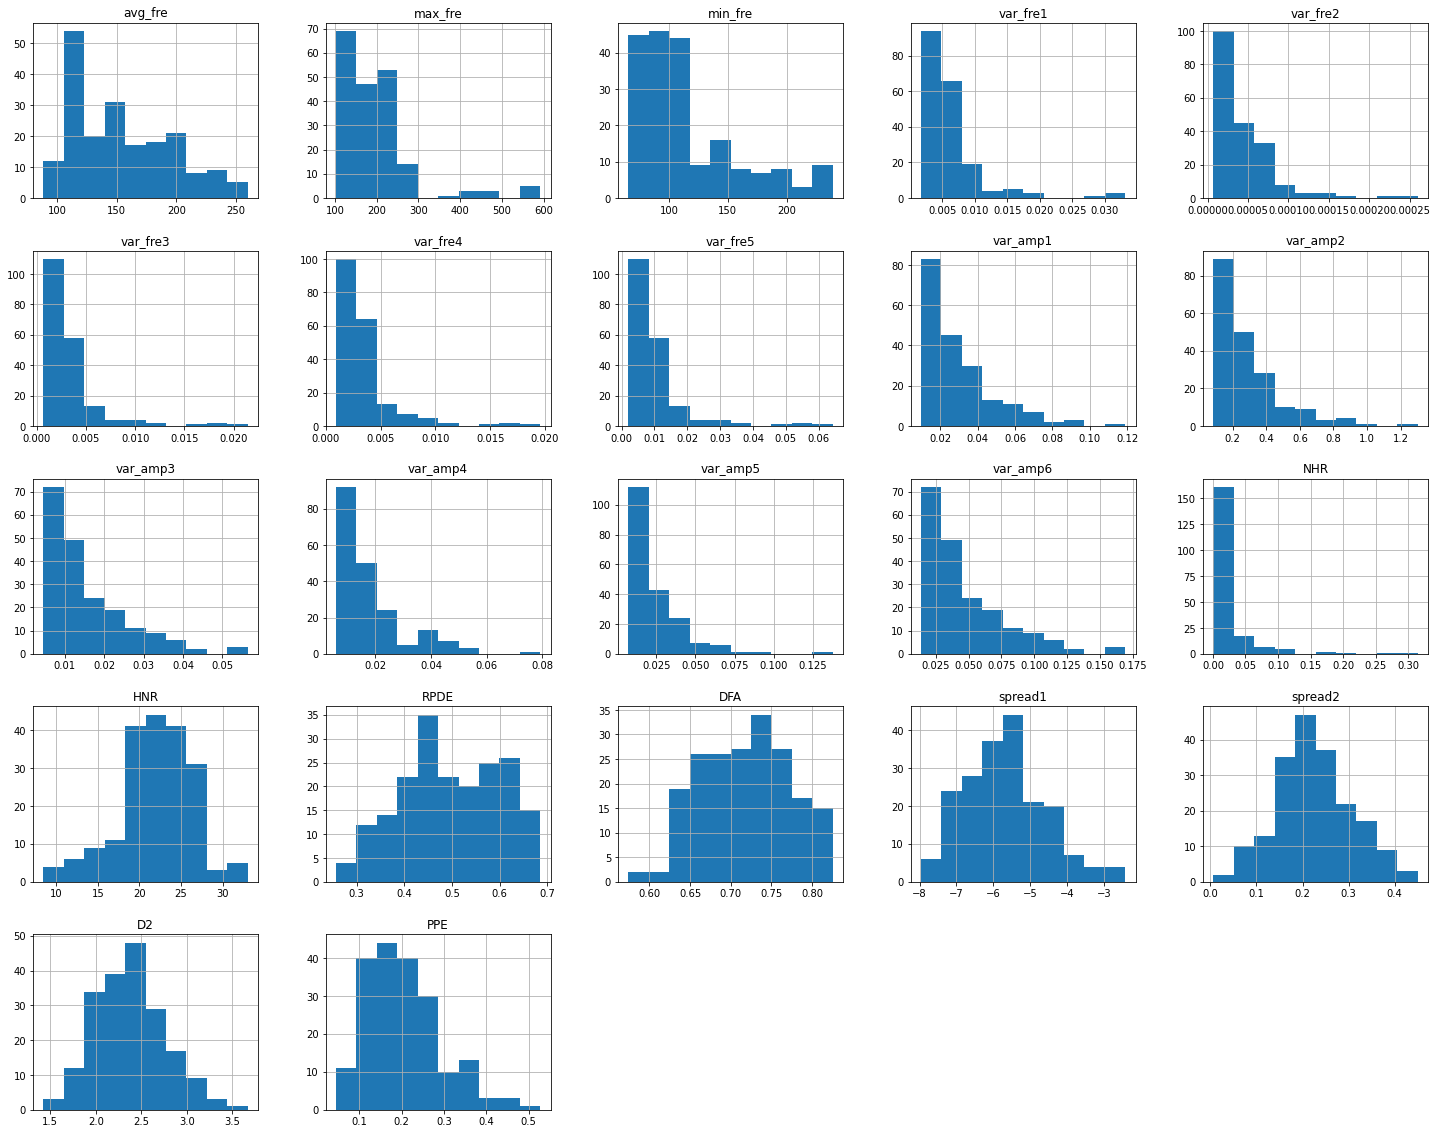

In [16]:
x1.hist(figsize=(25,20))
plt.show()

In [17]:
df=df[df.max_fre<=300]
df=df[df.var_fre1<=0.02]
df=df[df.var_fre2<=0.0001]
df=df[df.var_fre3<=0.01]
df=df[df.var_fre4<=0.01]
df=df[df.var_fre5<=0.02]
df=df[df.var_amp1<=0.10]
df=df[df.var_amp2<=1.0]
df=df[df.var_amp3<=0.04]
df=df[df.var_amp4<=0.050]
df=df[df.var_amp5<=0.075]
df=df[df.var_amp6<=0.125]
df=df[df.NHR<=0.15]

In [18]:
df.skew()

avg_fre     0.608391
max_fre     0.290164
min_fre     1.247241
var_fre1    0.843153
var_fre2    0.756592
var_fre3    0.811867
var_fre4    1.142506
var_fre5    0.811544
var_amp1    1.077428
var_amp2    1.138932
var_amp3    1.128533
var_amp4    1.376069
var_amp5    1.096979
var_amp6    1.128416
NHR         2.635106
HNR        -0.035596
status     -1.057890
RPDE       -0.066659
DFA        -0.132660
spread1     0.283933
spread2     0.158902
D2          0.485240
PPE         0.535763
dtype: float64

<AxesSubplot:xlabel='NHR', ylabel='Density'>

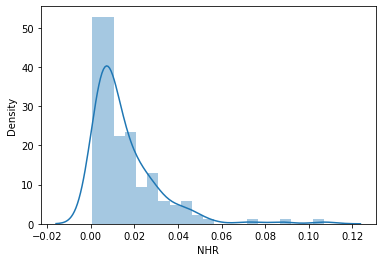

In [19]:
sns.distplot(df['NHR'])

In [20]:
df=df[df.NHR<=0.06]
df.skew()

avg_fre     0.629564
max_fre     0.328258
min_fre     1.245583
var_fre1    0.699469
var_fre2    0.769365
var_fre3    0.813203
var_fre4    1.212263
var_fre5    0.812495
var_amp1    1.063387
var_amp2    1.136743
var_amp3    1.116058
var_amp4    1.381370
var_amp5    1.098219
var_amp6    1.115979
NHR         1.327245
HNR         0.174386
status     -1.064996
RPDE       -0.061493
DFA        -0.133070
spread1     0.298066
spread2     0.123992
D2          0.194425
PPE         0.553609
dtype: float64

# Correlation Matrix

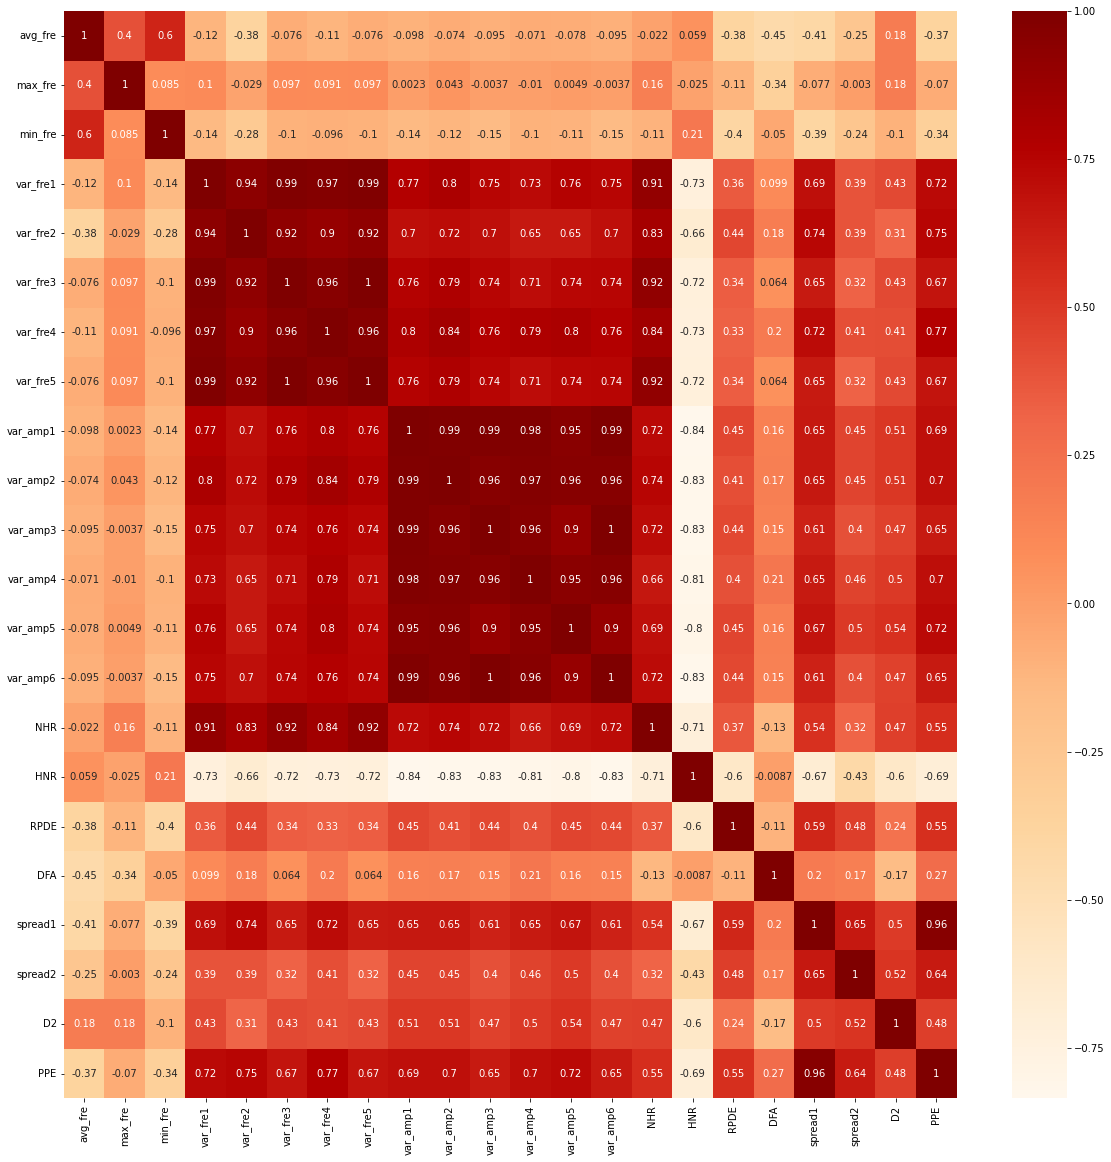

In [21]:
correl=x1.corr()
plt.figure(figsize=(20,20))
sns.heatmap(correl,annot=True,cmap='OrRd')
plt.show()

In [22]:
#Scale the features to between -1 and 1
scaler=MinMaxScaler((-1,1))
x1=scaler.fit_transform(x)
y1=y

In [23]:
#Split the dataset

xtrain,xtest,ytrain,ytest=train_test_split(x1, y1, test_size=0.2)

In [24]:
# Train the model
from xgboost import XGBClassifier


model=XGBClassifier()
model.fit(xtrain,ytrain)
predict=model.predict(xtest)


[13:46:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
print(accuracy_score(ytest,predict)*100)

92.3076923076923


# Implementing Confusion Matrix

Text(0.5, 1.0, 'Output Confusion Matrix')

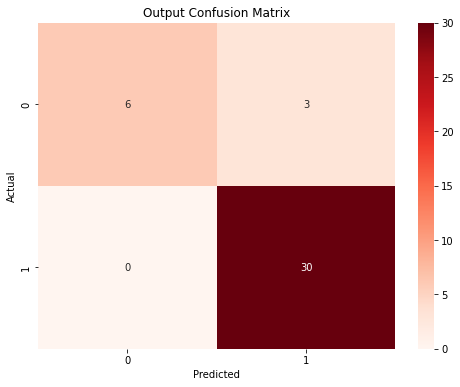

In [26]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(ytest,predict)
plt.figure(figsize=(8,6))
fg=sns.heatmap(cm,annot=True,cmap="Reds")
figure=fg.get_figure()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Output Confusion Matrix")

# Output Display

In [27]:
pd.DataFrame({'actual':ytest,'predict':predict})

actual  predict
0        1        1
1        1        1
2        0        0
3        0        1
4        0        0
5        1        1
6        1        1
7        1        1
8        0        1
9        1        1
10       1        1
11       1        1
12       1        1
13       0        0
14       1        1
15       1        1
16       1        1
17       1        1
18       1        1
19       1        1
20       1        1
21       1        1
22       1        1
23       1        1
24       1        1
25       1        1
26       0        0
27       1        1
28       1        1
29       1        1
30       1        1
31       0        0
32       1        1
33       1        1
34       0        0
35       1        1
36       0        1
37       1        1
38       1        1

# Prediction With New Input 

In [28]:
newinput=[[274.688,240.005,174.287,0.01360,0.01008,0.00624,0.00564,0.01873,1.02308,0.256,0.51268,0.01365,0.81667,0.63804,0.10715,6.883,0.607567,0.158453,3.679772,0.131728]]


In [29]:
output=model.predict(newinput)
output

array([1])